# 가위바위보 이미지 분류기

<br />

#### 목표
  일반적인 딥러닝 개발 순서인 **데이터 준비 → 딥러닝 네트워크 설계 → 학습 → 테스트(평가)**에 따라 가위바위보 이미지를 분류하는 이미지 분류기 모델을 만들어 본다.
  
<br />
<br />

## 데이터 준비
#### 1. 데이터 수집
* 사진 데이터를 모아 rock, scissor, paper 폴더에 분류하였다.
* data spec
    * image amount : 8913(가위 : 3005, 바위 : 2902, 보 : 3006)
    * test set : 램덤하게 뽑은 100개의 데이터
    * validation set : 램덤하게 뽑은 100개의 데이터
    * train set : 8713

In [1]:
# 이미지 데이터들은 data 디렉토리 하위에 rock, scissor, paper로 분류되어 있다.
!ls -l ./data

합계 244
drwxr-xr-x 2 aiffel aiffel 86016  1월  5 23:46 paper
drwxr-xr-x 2 aiffel aiffel 77824  1월  5 23:46 rock
drwxr-xr-x 2 aiffel aiffel 86016  1월  5 23:46 scissor


#### 2. 데이터 리사이징

In [2]:
#import packages
import numpy as np
import os, glob
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
def resize_image(workspace_dir_path):
    image_dir_paths = [ workspace_dir_path + "/scissor", workspace_dir_path + "/rock", workspace_dir_path + "/paper"]

    for image_dir_path in image_dir_paths:
        images=glob.glob(image_dir_path + "/*.jpg")

        # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
        target_size=(28,28)
        for img in images:
            old_img=Image.open(img)
            new_img=old_img.resize(target_size,Image.ANTIALIAS)
            new_img.save(img,"JPEG")

        print(image_dir_path + " 이미지 resize 완료!")
        
workspace_dir_path = os.getenv("HOME") + "/workspace/aiffel-exploation-workspace/E1_rock_scissor_paper/data"
resize_image(workspace_dir_path)

/home/aiffel/workspace/aiffel-exploation-workspace/E1_rock_scissor_paper/data/scissor 이미지 resize 완료!
/home/aiffel/workspace/aiffel-exploation-workspace/E1_rock_scissor_paper/data/rock 이미지 resize 완료!
/home/aiffel/workspace/aiffel-exploation-workspace/E1_rock_scissor_paper/data/paper 이미지 resize 완료!


#### 3. 데이터 불러오기

In [7]:
def load_data(img_path, number_of_data=300):
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1       
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
            
    print("입력된 이미지 개수는",idx,"입니다.")
    return imgs, labels

(8913, 28, 28, 3)
입력된 이미지 개수는 8913 입니다.
라벨:  0


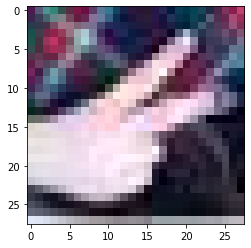

In [8]:
image_dir_path = os.getenv("HOME") + "/workspace/aiffel-exploation-workspace/E1_rock_scissor_paper/data"
(x, y)=load_data(image_dir_path, 8913)

# 데이터가 잘 불러와 졌는지 확인
plt.imshow(x[0])
print('라벨: ', y[0])

#### 4. 데이터 전처리
* 정규화 : 현재 이미지 데이터가 0\~255 사이의 값을 가지므로 이를 0\~1 사이의 값을 가지도록 정규화 시켜준다.
* reshape : 이후 단계에서 만들 네트워크의 입력은 *( 데이터의 갯수, 이미지 크기 x, 이미지 크기 y, 채널수)*의 형태를 가지므로 입력 데이터의 형태를 변환 시켜준다.

In [11]:
x_norm = x / 255.0
x_reshaped = x_norm.reshape( -1, 28, 28, 3)

print("After Normalization - min : {}, max : {}".format(np.min(x_reshaped), np.max(x_reshaped)))
print("After Reshape - x_reshaped shape : {}".format(x_reshaped.shape))

After Normalization - min : 0.0, max : 1.0
After Reshape - x_reshaped shape : (8913, 28, 28, 3)


#### 5. 데이터 분할
데이터를 train set, validation set, test set으로 분할한다.

In [13]:
random_state = np.random.RandomState(seed=545)

# 데이터를 랜덤하게 섞고, 학습 데이터와 테스트 데이터를 8:2 비율로 분할한다.
# 테스트 데이터를 다시 절반으로 나누어 검증 데이터로 삼는다.
# ==> train set : validation set : test set = 8 : 1 : 1
(x_train, x_test, y_train, y_test) = train_test_split(x_reshaped, y, test_size=0.2, random_state=random_state)
(x_test, x_validation, y_test, y_validation) = train_test_split(x_test, y_test, test_size=0.5, random_state=random_state)

print("x_train shape: {}".format(x_train.shape))
print("x_test shape: {}".format(x_test.shape))
print("x_validation shape: {}".format(x_validation.shape))

x_train shape: (7130, 28, 28, 3)
x_test shape: (891, 28, 28, 3)
x_validation shape: (892, 28, 28, 3)


라벨:  2


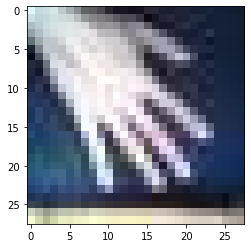

In [14]:
# train set 확인
plt.imshow(x_train[0])
print('라벨: ', y_train[0])

라벨:  0


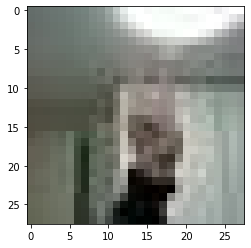

In [15]:
# test set 확인
plt.imshow(x_test[0])
print('라벨: ', y_test[0])

라벨:  1


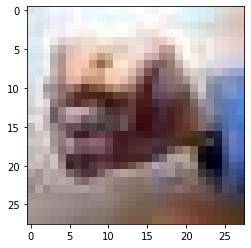

In [16]:
# validation set 확인
plt.imshow(x_validation[0])
print('라벨: ', y_validation[0])

## 딥러닝 네트워크 설계
2개의 Conva2D 레이어를 가지는 type A 모델과 3개의 Conva2D 레이어를 가지는 type B 모델 두 가지를 설계하였다.

In [45]:
def get_modal_type_A(n_channel_1, n_channel_2, n_dense):
    # print(n_channel_1, n_channel_2, n_dense)
    model = keras.models.Sequential([
        keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)),
        keras.layers.MaxPool2D(2,2),
        keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'),
        keras.layers.MaxPool2D(2,2),
        keras.layers.Flatten(), # 2D -> 1D
        keras.layers.Dense(n_dense, activation='relu'),
        keras.layers.Dense(3, activation='softmax')
    ])
    
    #model.summary()
    
    return model

In [24]:
def get_modal_type_B(n_channel_1, n_channel_2, n_channel_3, n_dense):
    model = keras.models.Sequential([
        keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)),
        keras.layers.MaxPool2D(2,2),
        keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'),
        keras.layers.MaxPool2D(2,2),
        keras.layers.Conv2D(n_channel_3, (3,3), activation='relu'),
        keras.layers.MaxPool2D(2,2),
        keras.layers.Flatten(), # 2D -> 1D
        keras.layers.Dense(n_dense, activation='relu'),
        keras.layers.Dense(3, activation='softmax')
    ])
    
    model.summary()
    
    return model

## 학습
다양한 하이퍼 파라미터를 적용하여 학습시키고 validation set을 이용하여 이를 평가

In [25]:
def train_model(model, x, y, repeat=10):
    model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])
    
    model.fit(x, y, epochs=repeat)

In [26]:
def test_model(model, x, y):
    test_loss, test_accuracy = model.evaluate(x, y, verbose=2)
    print("====> test_loss: {} ".format(test_loss))
    print("====> test_accuracy: {}".format(test_accuracy))

In [34]:
hyper_params_A = [(16, 16, 16), (16, 32, 32), (32, 32, 32), (32, 64, 64), (64, 64, 64), (64, 128, 128)]
for parm in hyper_params_A:
    model_type_A = get_modal_type_A(*parm)
    train_model(model_type_A, x_train, y_train)
    test_model(model_type_A, x_validation, y_validation)

16 16 16
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 16)        2320      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                6416      
_________________________________________________________________
dense_5 (Dense)              (None, 3)       

In [36]:
hyper_params_B = [(16, 16, 16, 16), (16, 32, 32, 32), (16, 32, 64, 64), (32, 32, 32, 32), (32, 32, 64, 64),
                  (32, 64, 64, 64), (32, 64, 128, 128)]
for parm in hyper_params_B:
    model_type_B = get_modal_type_B(*parm)
    train_model(model_type_B, x_train, y_train)
    test_model(model_type_B, x_validation, y_validation)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 11, 11, 16)        2320      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 3, 3, 16)          2320      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 1, 1, 16)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 16)               

* 하이퍼 파라미터 변화에 따른 model type A의 accuracy 변화

| 회차 | n_channel_1 | n_channel_2 | n_dense | validation accuracy |
|:----:|:-----------:|:-----------:|:-------:|:-------------------:|
| 1    | 16          | 16          | 16      | 0.8408071994781494  |
| 2    | 16          | 32          | 32      | 0.9248878955841064  |
| 3    | 32          | 32          | 32      | 0.9192824959754944  |
| 4    | 32          | 64          | 64      | 0.9473094344139099  |
| 5    | 64          | 64          | 64      | 0.9562780261039734  |
| 6    | 64          | 128         | 128     | 0.9854260087013245  |

<br />

* 하이퍼 파라미터 변화에 따른 model type B의 accuracy 변화

| 회차 | n_channel_1 | n_channel_2 | n_channel_3 | n_dense | validation accuracy |
|:----:|:-----------:|:-----------:|:-----------:|:-------:|:-------------------:|
| 1    | 16          | 16          | 16          | 16      | 0.7858744263648987  |
| 2    | 16          | 32          | 32          | 32      | 0.8957399129867554  |
| 3    | 16          | 32          | 64          | 64      | 0.9058296084403992  |
| 4    | 32          | 32          | 32          | 32      | 0.9125560522079468  |
| 5    | 32          | 32          | 64          | 64      | 0.9417040348052979  |
| 6    | 32          | 64          | 64          | 64      | 0.9473094344139099  |
| 7    | 32          | 64          | 128         | 128     | 0.9573991298675537  |

<br />

가장 accuracy가 높은 6회차 하이퍼 파라미터를 가지는 type A 모델을 선정하여 다음 테스트를 진행한다.

In [40]:
final_model = get_modal_type_A(64, 128, 128)
train_model(final_model, x_train, y_train)

64 128 128
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 26, 26, 64)        1792      
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 11, 11, 128)       73856     
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 5, 5, 128)         0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 3200)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 128)               409728    
_________________________________________________________________
dense_33 (Dense)             (None, 3)    

## 테스트

In [41]:
test_model(final_model, x_test, y_test)

28/28 - 0s - loss: 0.0779 - accuracy: 0.9787
====> test_loss: 0.07785475999116898 
====> test_accuracy: 0.9786756634712219


In [ ]:
test_model(model_type_B, x_test_reshaped, y_test)

이번 프로젝트의 결과를 가장 크게 좌우한 것은 <U>데이터의 양</U>이었다. 300개의 데이터를 가지고 했던 초기단계에서는 accuracy가 0.4 근처를 맴돌았고, 이는 하이퍼 파라미터를 아무리 조절하여도 개선이 되지 않았다. 하지만 이후 다량의 데이터를 수집하여 프로젝트에 투입하였고 0.97이라는 놀라운 수치에 도달 할 수 있었다. 개인적으로 느끼기에는 accuracy가 너무 갑자기 급등하여 데이터양에 따른 accuracy 변화를 좀 더 자세히 살펴보고자 한다.

#### 실험 내용
* train data set의 양에 따른 test accuracy의 변화를 관찰한다.
* `get_modal_type_A(64, 128, 128)`를 통해 얻어지는 동일한 모델을 이용하여 실험을 진행한다.
* 실험 과정
    1. 새로운 모델을 생성한다.
    2. N개의 train data를 이용하여 1에서 생성한 모델을 학습시킨다. N는 10에서 시작하여 회차를 거듭할 때마다 10개 씩 증가한다.
    3. N이 7130을 초과하게 되면 실험을 종료한다. 그렇지 않다면 1로 돌아가 실험을 반복한다.

In [46]:
  
# x_train shape: (7130, 28, 28, 3)
# x_test shape: (891, 28, 28, 3)
# x_validation shape: (892, 28, 28, 3)

def get_model_test_result(model, x, y, N):
    test_loss, test_accuracy = model.evaluate(x, y, verbose=False)
    print('{} test complete == accruacy : {}, loss : {}'.format(N, test_accuracy, test_loss))
    return [test_loss, test_accuracy]

def train_model_with_no_log(model, x, y, repeat, N):
    model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])
    
    model.fit(x, y, epochs=repeat, verbose=False)
    print('{} train complete -- accruacy : {}, loss : {}'.format(N, model.history.history['accuracy'][-1], model.history.history['loss'][-1]))

loss_list = []
accurcy_list = []

N = 10
while N <= 7130:
    model = get_modal_type_A(64, 128, 128)
    train_model_with_no_log(model, x_train[:N], y_train[:N], 10, N)
    (loss, accuracy) = get_model_test_result(model, x_test, y_test, N)
    
    loss_list.append(loss)
    accurcy_list.append(accuracy)
    N += 10
    

10 train complete -- accruacy : 0.8999999761581421, loss : 0.40092024207115173
10 test complete == accruacy : 0.3400673270225525, loss : 1.9005327224731445
20 train complete -- accruacy : 0.699999988079071, loss : 0.6829968094825745
20 test complete == accruacy : 0.34455668926239014, loss : 1.3223410844802856
30 train complete -- accruacy : 0.6666666865348816, loss : 0.8006798028945923
30 test complete == accruacy : 0.3411896824836731, loss : 1.2011361122131348
40 train complete -- accruacy : 0.675000011920929, loss : 0.816357433795929
40 test complete == accruacy : 0.3490460216999054, loss : 1.1658681631088257
50 train complete -- accruacy : 0.6200000047683716, loss : 0.7232769131660461
50 test complete == accruacy : 0.36139169335365295, loss : 1.2296626567840576
60 train complete -- accruacy : 0.7333333492279053, loss : 0.7974259853363037
60 test complete == accruacy : 0.3961840569972992, loss : 1.1196043491363525
70 train complete -- accruacy : 0.5428571701049805, loss : 0.813436567

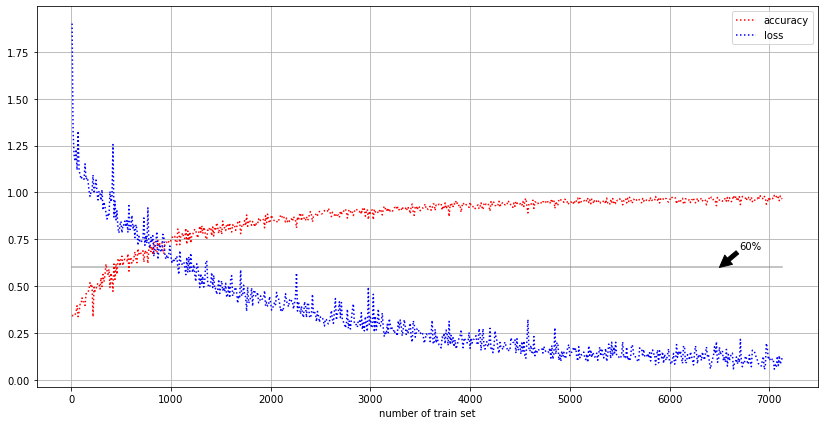

In [91]:
from matplotlib import pyplot as plt
import numpy as np

x_axis = np.arange(10, 7140, 10)
score = [0.6] * 713

plt.rcParams["figure.figsize"] = (14,7)
plt.rcParams['axes.grid'] = True
plt.plot(x_axis, score, alpha=.6, color='gray')
plt.plot(x_axis, accurcy_list, ':r',label='accuracy')
plt.plot(x_axis, loss_list,':b',label='loss')
plt.annotate('60%',xy=(6500,0.6),xytext=(6700,0.7),arrowprops={'color':'black'})
plt.xlabel('number of train set')
plt.legend(loc='upper right')
plt.show()

In [88]:
min_60_x = 0
for idx in range(0, 713):
    min_60_x = idx if accurcy_list[idx] <= 0.6 else min_60_x

print("0.6 threshold : {}".format(min_60_x * 10 + 10))
print("min accuracy : {}, max accuracy : {}".format(min(accurcy_list), max(accurcy_list)))

0.6 threshold : 580
min accuracy : 0.33670035004615784, max accuracy : 0.9842873215675354


#### 실험결과
1. train set을 580개 이상 사용하게 되면 accurcy가 60% 이상임이 관찰 되었다.
2. train set을 10개에서 7130개를 사용하였을 때, accuracy는 *0.33670035004615784 ~ 0.9842873215675354*사이의 값을 가지게 된다
3. train set의 양이 증가함에 따라 accuracy가 증가하는 경향을 띄며 accuracy의 값은 1로 수렴해 간다.

## 결론
이번 프로젝트의 핵심은 **데이터의 중요성**이었다. 처음 300개의 데이터를 이용하여 학습을 할 때만 하여도 40% 근처의 accuracy를 얻을 수 있었지만, 다량의 데이터를 이용하여 학습을 진행하였더니 더 발전한 accuracy를 얹을 수 있었다. 더불어 데이터의 양 뿐만 아니라 질 또한 학습에 지대한 영향을 미치는 것을 체감할 수 있었다. 이 문서를 쓸 때는 사용하지 않았지만, 초기에 300개의 데이터를 사용한 실험 이후, 약 600개 정도의 데이터를 추가로 수집하여 모델을 학습 시켰었는데, 그 때의 accuracy는 58% 근처를 멤돌았었다. 그 후 기존 데이터를 모두 삭제하고 데이터 수집 단계부터 새로이 프로젝트를 진행하였고 그 결과가 지금 작성하고 있는 이 문서이다. 위의 실험결과에서 비슷한 양의 데이터와 동일한 하이퍼 파라매터를 사용하여 학습되었을 때, 이후에 학습 된 모델의 성능이 더 좋을 것을 확인할 수 있다. 이것은 학습에 사용된 데이터의 질일 후자가 더 좋았기 때문이라고 생각된다.

프로젝트를 진행하면서 다양한 자료들을 읽고 많은 것을 배웠지만 아래의 사항들은 아직 모호나 채로 남아있다. 차후에 시간이 주어진다면 추가로 공부를 해보아야겠고, 아직 갈 길이 매우 멀다는 경각심이 든 이틀이었다.
* train loss의 정확한 의미
* 모델에 사용된 레이어(MaxPool2D, Conv2D, Dense)와 그 파라매터들의 정확한 의미
* 효율적인 하이퍼 파라미터 선정 방식

#### ref
* [[Python] sklearn의 train_test_split() 사용법](http://blog.naver.com/siniphia/221396370872)
* [파이썬을 이용한 데이타 시각화 #1 - Matplotlib 기본 그래프 그리기](https://bcho.tistory.com/1201)
* [두 연속변수의 관계 :: Python 데이터 시각화 기초](https://mindscale.kr/course/python-visualization-basic/relation)
* [딥러닝 CNN 케라스(Keras) - ImageDataGenerator를 이용한 가위바위보 이미지 분류 모델](https://blog.naver.com/lois7109/222177838839)
* [Convolution Neural Networks for MNIST data](https://medium.com/@mlguy/convolution-neural-networks-for-mnist-data-68807f662e7a)
* [How to Treat Overfitting in Convolutional Neural Networks](https://www.analyticsvidhya.com/blog/2020/09/overfitting-in-cnn-show-to-treat-overfitting-in-convolutional-neural-networks/)